In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import sys
sys.path.append('../')

from proxy_apps.framework.gpu import GPU
from proxy_apps.apps import LSTMProxyApp
from proxy_apps.data.grid import TransientDataset

2022-12-09 13:06:37.069245: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Initialize App

In [2]:
# get the framework
framework = GPU(
    machine_name="deception"
)

# get the interface
interface = framework.use_pytorch()

# load the proxy app
app = LSTMProxyApp("gpu")

[INFO] Device Type: cpu
[WARNING] No GPUs found, falling back to CPUs
[INFO] Python Data Type: float64
[INFO] Framework Data Type: torch.float64


In [3]:
# init app manager
interface.init_app_manager(
    app=app,
    app_name="LSTMProxyApp",
    output_dir="/qfs/people/jain432/pacer_remote/output/test/",
    mixed_precision_support=True,
    mgpu_support=True
)


[INFO] Selected App: LSTMProxyApp
[INFO] Output Data Directory: /qfs/people/jain432/pacer_remote/output/test
[INFO] App Supports Mixed Precision: True
[INFO] App Supports MGPUs: True
[INFO] Disabling Multi-GPU Support. To use multiple gpus, provide a valid Multi-GPU strategy (HVD/DDP) when initializing the framework.


## Load Data and Prepare Dataloader

In [4]:
# initialize data manager
interface.init_data_manager(
    data_dir="/qfs/people/jain432/pacer_remote/data/NewTestScenarios/",
    file_format="mat",
    data_manager="TimeSeries",
    train_files=2,
    test_files="/qfs/people/jain432/pacer_remote/data/TrainingDataIEEE68bus/",
    val_files=0,
    shuffle=True
)


[INFO] Training Data Directory: /qfs/people/jain432/pacer_remote/data/NewTestScenarios/
[INFO] Found 180 `mat` files
[INFO] Training on 2/180 `mat` files
[INFO] Validation on 0/180 `mat` files
[INFO] Testing on 30/180 `mat` files
[INFO] Number of training files: 2
[INFO] Number of validation files: 0


In [5]:
print(
    "Train (%d-%d): %s\nVal (%d-%d): %s\nTest (%d-%d): %s" 
    %(
        len(interface.data_manager._TRAIN_FILES),
        interface.data_manager._N_TRAIN_FILES,
        interface.data_manager._TRAIN_DATA_DIR, 
        len(interface.data_manager._VAL_FILES),
        interface.data_manager._N_VAL_FILES,
        interface.data_manager._VAL_DATA_DIR,
        len(interface.data_manager._TEST_FILES),
        interface.data_manager._N_TEST_FILES,
        interface.data_manager._TEST_DATA_DIR
    )
)

Train (2-2): /qfs/people/jain432/pacer_remote/data/NewTestScenarios/
Val (0-0): /qfs/people/jain432/pacer_remote/data/NewTestScenarios/
Test (30-30): /qfs/people/jain432/pacer_remote/data/TrainingDataIEEE68bus/


In [6]:
# load training data
load_prep_params = {
	"dataloader": "torch.utils.data.Dataset",
	"n_rows": 1400,
	"n_cols": 136,
	"repeat_cols": 1,
	"iw_params": {
		"window_size": 60,
		"shift_size": 1,
		"stride": 1,
		"start_at": 0,
		"leave_last": 33
	},
	"ow_params": {
		"window_size": 30,
		"shift_size": 1,
		"stride": 1,
		"start_at": 60,
		"leave_last": 3
	}
}
# training data
training_data = interface.load_data(
    data_files=interface.data_manager._TRAIN_FILES,
    data_params=load_prep_params,
    sampler=None,
	batch_size=64
)
# test data
test_data = interface.load_data(
    data_files=interface.data_manager._TEST_FILES,
    data_params=load_prep_params,
    sampler=None
)

## Model Training

### PyTorch

In [7]:
import torch
from torch.autograd import Variable

In [8]:
class LSTMEasy(torch.nn.Module):
    def __init__(self, model_name, model_parameters, device=None):
        super(LSTMEasy, self).__init__()
        self.bw_size = model_parameters["bw_size"] # size of the backward window
        self.fw_size = model_parameters["fw_size"] # size of the backward window
        self.n_features = model_parameters["n_features"] # size of the backward window
        self.device = device
        
        self.hidden_size4 = 64
        self.lstm4_layer   = torch.nn.LSTM(
                                hidden_size=self.hidden_size4, 
                                input_size=self.n_features, 
                                batch_first=True
                            )
        
        self.dense_layer   = torch.nn.Linear(
                                in_features=self.hidden_size4, 
                                out_features=self.fw_size * self.n_features
                            )
        
    def forward(self,x):
        h_4 = Variable(torch.zeros(1, x.size(0), self.hidden_size4))
        if self.device is not None:
            h_4 = h_4.to(self.device) #hidden state
        c_4 = Variable(torch.zeros(1, x.size(0), self.hidden_size4))
        if self.device is not None:
            c_4 = c_4.to(self.device) #internal state
        # h_4, c_4 = self.lstm4_layer(h_3, (h_4, c_4)) #Final 
        h_4, c_4 = self.lstm4_layer(x, (h_4, c_4)) #Final Output
        #print(h_4[:, -1, :].shape)
        
        out = self.dense_layer(h_4[:, -1, :])
        #print(out.shape)
        
        return out.view((out.shape[0], self.fw_size, self.n_features))

# compare actual and window data
def compare_lineplots(ax1_data, ax1_label, ax2_data, ax2_label):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
    ax=axes[0]
    ax.plot(ax1_data);
    ax.set_title(ax1_label)
    ax=axes[1]
    ax.plot(ax2_data);
    ax.set_title(ax2_label)
    fig.tight_layout()

import time
def train_loop(model, training_data, optimizer, criterion, n_epochs, device="cpu"):
    for epoch in range(n_epochs):
        total_loss = torch.tensor(0.0, device=device)
        num_batches = torch.tensor(0, device=device)
        
        epoch_start_time = time.time()
        # go through all the batches generated by dataloader
        for i, (inputs, targets) in enumerate(training_data):
            # if i > 100: break
            # move data to GPU
            # print(inputs.shape, targets.shape)
            inputs, targets        = inputs.to(device), targets.to(device)
            
            # clear the gradients
            optimizer.zero_grad()#set_to_none=True)
            
            with torch.cuda.amp.autocast(enabled=False):
                # compute the model output
                yhat = model(inputs)
                
                # calculate loss
                loss = criterion(yhat, targets)
            
                # credit assignment
                loss.backward()
            
                # update model weights
                optimizer.step()
            
            # updating the loss
            total_loss += loss
            num_batches += 1
        
        print("[INFO] Epoch (", epoch+1, "/", n_epochs, "): MSE: ", total_loss)

LSTMEasy(
  (lstm4_layer): LSTM(136, 64, batch_first=True)
  (dense_layer): Linear(in_features=64, out_features=4080, bias=True)
)
torch.Size([64, 30, 136])


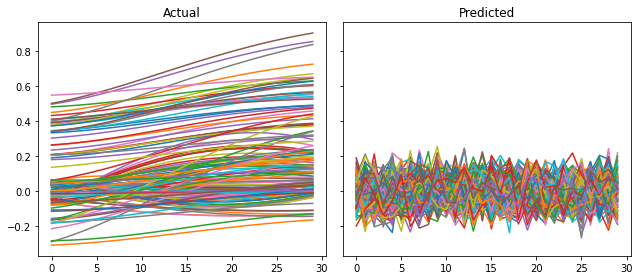

In [9]:
# build and predict on one sample
pt_model = LSTMEasy(
    "LSTMEasy", 
    {"bw_size": 60, "fw_size": 30, "n_features": 136}
)
print(pt_model)

# select and predict
inputs, targets = iter(training_data).next()
predicted = pt_model(inputs)
print(predicted.shape)

# compare prediction with actuals
compare_lineplots(
    targets[0, :, :], "Actual",
    predicted.detach().numpy()[0, :, :], "Predicted"
)


In [11]:
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(
#                 pt_model.parameters(), 
#                 lr=0.08
#             )
optimizer = torch.optim.Adagrad(
        pt_model.parameters(), 
        lr=0.08
    )
# optimizer = torch.optim.LBFGS(pt_model.parameters(), lr=0.08)
train_loop(pt_model, training_data, optimizer, criterion, 20)

[INFO] Epoch ( 1 / 20 ): MSE:  tensor(0.4253, grad_fn=<AddBackward0>)
[INFO] Epoch ( 2 / 20 ): MSE:  tensor(0.0605, grad_fn=<AddBackward0>)
[INFO] Epoch ( 3 / 20 ): MSE:  tensor(0.0473, grad_fn=<AddBackward0>)
[INFO] Epoch ( 4 / 20 ): MSE:  tensor(0.0413, grad_fn=<AddBackward0>)
[INFO] Epoch ( 5 / 20 ): MSE:  tensor(0.0375, grad_fn=<AddBackward0>)
[INFO] Epoch ( 6 / 20 ): MSE:  tensor(0.0348, grad_fn=<AddBackward0>)
[INFO] Epoch ( 7 / 20 ): MSE:  tensor(0.0327, grad_fn=<AddBackward0>)
[INFO] Epoch ( 8 / 20 ): MSE:  tensor(0.0310, grad_fn=<AddBackward0>)
[INFO] Epoch ( 9 / 20 ): MSE:  tensor(0.0295, grad_fn=<AddBackward0>)
[INFO] Epoch ( 10 / 20 ): MSE:  tensor(0.0282, grad_fn=<AddBackward0>)
[INFO] Epoch ( 11 / 20 ): MSE:  tensor(0.0270, grad_fn=<AddBackward0>)
[INFO] Epoch ( 12 / 20 ): MSE:  tensor(0.0258, grad_fn=<AddBackward0>)
[INFO] Epoch ( 13 / 20 ): MSE:  tensor(0.0247, grad_fn=<AddBackward0>)
[INFO] Epoch ( 14 / 20 ): MSE:  tensor(0.0237, grad_fn=<AddBackward0>)
[INFO] Epoch ( 

torch.Size([64, 30, 136])


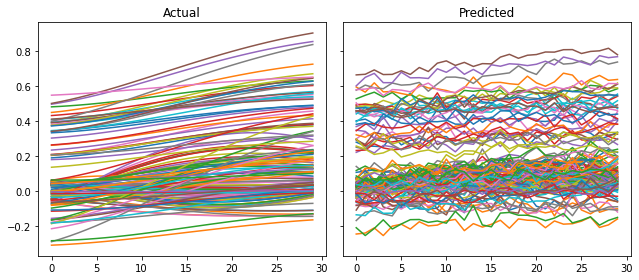

In [12]:
# after training comparison
predicted = pt_model(inputs)
print(predicted.shape)

# compare prediction with actuals
compare_lineplots(
    targets[0, :, :], "Actual",
    predicted.detach().numpy()[0, :, :], "Predicted"
)

In [ ]:
# ## Initialize ProxyTSPRD
# # model info
# _MODEL_NAME = "TFDataOptMGPU"
# _N_EPOCHS = 2
# _BATCH_SIZE = 32
# _MIXED_PRECISION = False

# # machine info
# _MACHINE_NAME = 'A100'
# _N_GPUS = 1
# _N_CPUS = 16

# # paths
# _CURR_DIR = os.path.dirname('./')
# _DATA_DIR = _CURR_DIR
# _MODEL_DIR = _CURR_DIR

# _FRAMEWORK = 'TF'

# interface = ProxyTSPRD('config.json', _MODEL_NAME, _N_EPOCHS, _BATCH_SIZE, _MIXED_PRECISION, 
#                  _MACHINE_NAME, _N_GPUS, _N_CPUS,
#                  _DATA_DIR, _MODEL_DIR, _FRAMEWORK)

In [ ]:
# interface.load_data(_CURR_DIR)

In [ ]:
# interface.train_model()